# Deep learning for text and sequences

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Working with text data

In the age of information, text is everywhere. It can be understood either as a sequence of characters or a sequence of words. However, we cannot simply input raw text to a neural network. Like other machine learning tasks, the text must be encoded (vectorized) into a numeric tensor that describes the text. This can be done in many ways which we will explore below: 
* Segmenting text into words and transforming each word into a vector
* Segmenting text into characters and transforming each character into a vector
* Extracting `n-grams` of words or characters and tranforming each n-gram into a vector <br> (`n-grams` are overlapping groups of multiple consecutive words or characters)

### One-hot encoding of words or characters

One-hot encoding is the most common, most basic way to turn a token into a vector. It consists in associating a unique index to every word, then turning this index i into a vinary vector of size N. One-hot encoding can alos be done at the charicter level as well. 

As a quick exercise, we will implement the one-hot encoding of words ourself. 

In [3]:
samples = [
    'The cat sat on the mat',
    'The dog ate my homework',
    ]

In [4]:
token_index = {}
for sample in samples:
    sample = sample.lower()
    for word in sample.split():
        # In real life we should strip the punctuation, I will skip this 
        #    in my exercise because in practice I will use a library.
         if word not in token_index:
            token_index[word] = len(token_index) + 1
            # note: we do not associate index 0 to anything. 

In [5]:
# limit the vector space to only the top N words.
max_length = 10

results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index[word.lower()]
        results[i, j, index] = 1

In [6]:
results

array([[[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,

We can of course to this using built-in utilities with keras. This will better handle any special characters and exceptions that we might encounter. 

In [7]:
from keras.preprocessing.text import Tokenizer

# Builds the word index
tokenizer = Tokenizer(num_words=10)
tokenizer.fit_on_texts(samples)

# Turns strings into lists of indices
sequences = tokenizer.texts_to_sequences(samples)

# One-hot binary representations (a little different than before)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

In [8]:
one_hot_results

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.]])

### Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". In contrast to one-hot encoding, word embeddings are low-dimensional floating point vectors which are learned from data. It is common to see word embeddings that are 255, 512, or 1024-dimensional when dealing with very large vocabularies; able to pack more information into far fewer dimensions than one-hot encoding.

#### Learning word embeddings

The geometric relationships between word vectors reflect the semantic relationships between these words. Word embeddings are meant to map human language into a vector space. A common example for meaningful gemetric transformations are "gender" and "plural" vectors. For instance, by adding a "female" vector to the vector "king", one may obtain the vector "queen". By adding a "plural" vector, one obtains "kings". Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors. 

A physicist or lawyer typically uses a different set of language in their day-to-day lives. Similarly, the optimal word embedding depends on the context of your task: an optimal word embedding for art critique sentiment model may look very different from the perfect embedding space for a legal document classification model. Thus, it is reasonable to learn a new embedding space with each new task. Keras makes this very easy. 

In [9]:
from keras.layers import Embedding

# The embedding takes two arguments
#    1. The number of possible tokens (1000)
#    2. The dimensionality of the embeddings (64)
embedding_layer = Embedding(1000, 64)

When you instatiate an `Embedding` layer, its weights are initially random. Of course this isn't very effivient, so it must be trained to your domain. Let's apply this idea to IMDB movie review sentiment prediction. We will restrict the movie reviews to the top 10k most common words and cut the reviews after only 20 words.

In [10]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000

# Cut texts after this number of words
maxlen = 20

# Load the data as lists of integers
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Turn our lists of integers into a 2D tensor of integers with shape '(samples, maxlen)'
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test  = preprocessing.sequence.pad_sequences(X_test,  maxlen=maxlen)

Our network will simply learn 8-dimensional embeddings for each fo the 10k words, turn the integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` layer on top for classification.

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


Considering we only look at the first 20 words in every review, a validation accuracy of ~76% is pretty impressive! 

By only flattening the embedded sequences and training a single `Dense` layer the model treats each word individually, without considering inter-word relations and sentence structure. Such a model would likely treat both *"this movie is shit"* and *"this movie is the shit"* as both being negative reviews. It would be much better to add recurrent layers or a 1D convolution layer on top of the embedded sequences to learn features that take into account the full sentence. We will try both of these options later on in the notebook.

In [12]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s - loss: 0.6560 - acc: 0.6485 - val_loss: 0.5907 - val_acc: 0.7146
Epoch 2/10
20000/20000 [==============================] - 0s - loss: 0.5189 - acc: 0.7594 - val_loss: 0.5117 - val_acc: 0.7364
Epoch 3/10
20000/20000 [==============================] - 0s - loss: 0.4512 - acc: 0.7933 - val_loss: 0.4949 - val_acc: 0.7470
Epoch 4/10
20000/20000 [==============================] - 1s - loss: 0.4190 - acc: 0.8068 - val_loss: 0.4905 - val_acc: 0.7538
Epoch 5/10
20000/20000 [==============================] - 0s - loss: 0.3965 - acc: 0.8197 - val_loss: 0.4914 - val_acc: 0.7572
Epoch 6/10
20000/20000 [==============================] - 0s - loss: 0.3784 - acc: 0.8311 - val_loss: 0.4953 - val_acc: 0.7592
Epoch 7/10
20000/20000 [==============================] - 1s - loss: 0.3624 - acc: 0.8419 - val_loss: 0.5004 - val_acc: 0.7574
Epoch 8/10
20000/20000 [==============================] - 0s -

#### Using Pre-Trained Word Embeddings

Sometimes, you might have so little data available that you could never use your data alone to learn an appropriate task-specific embedding of your vocabulary. Instead of learning word embeddings jointly with the problem you want to solve (as we just di), you could be loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties -- that captures general aspects of language structure. The rationale behind using pre-trained word embeddings in NLP is very much the same as that of using pre-trained convnets in image classification: we don't have enough data to learn the optimal features for a problem, but we expect the features that we need to be fairly generic.

While not the first, the most famous and successful word embedding algorithm is `Word2Vec`. There are many pre-computed databases of word embeddings included in keras; `Word2Vec` is one of them. Another popular choice is called "GloVe" (Global Vectors for Word Representation), it is an embedding technique based on factorizing a matrix of word co-occurence statistics.

#### From Raw text to word embeddings
Let's put everything together but using raw (pre-tokenized) IMBD data and a pre-trained word embedding.  

In [13]:
# Collect and label the training data
imdb_dir = 'raw_text'
train_dir = os.path.join(imdb_dir, 'train')

texts, labels = [], []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Now we'll vectorize the texts we collected and prepare a training and validation split. Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available, we will restrict the training data to only the first 200 samples. We will still use a 10k sample validation set to see how well we do. 

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100 
max_words = 10000
training_samples = 200
validation_samples = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Shuffle data before splitting the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
labels = labels[indices]
data = data[indices]

X_train = data  [:training_samples]
y_train = labels[:training_samples]
X_val   = data  [training_samples: training_samples + validation_samples]
y_val   = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


I downloaded the GloVe training created by crawling Wikipedia 2014 + Gigaword 5, but we need to do some pre-processing of the embedding.

In [15]:
glove_dir = 'glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer

In [16]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

Let's define the same model architecture as before.

In [17]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


One slight tweak however, is that we want to use our pre-trained embedding instead of training a new one. We do this by loading in our pre-trained weights and freezing the layer so that it will not be altered during training.

In [18]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Finally, let's train and evaluate our model:

In [19]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s - loss: 2.0332 - acc: 0.5150 - val_loss: 0.7081 - val_acc: 0.5278
Epoch 2/10
200/200 [==============================] - 0s - loss: 0.5196 - acc: 0.7500 - val_loss: 0.9993 - val_acc: 0.5016
Epoch 3/10
200/200 [==============================] - 0s - loss: 0.4038 - acc: 0.8550 - val_loss: 0.7128 - val_acc: 0.5466
Epoch 4/10
200/200 [==============================] - 0s - loss: 0.3290 - acc: 0.8650 - val_loss: 1.0479 - val_acc: 0.5001
Epoch 5/10
200/200 [==============================] - 0s - loss: 0.2385 - acc: 0.9400 - val_loss: 0.7049 - val_acc: 0.5737
Epoch 6/10
200/200 [==============================] - 0s - loss: 0.1111 - acc: 1.0000 - val_loss: 0.7437 - val_acc: 0.5609
Epoch 7/10
200/200 [==============================] - 0s - loss: 0.3128 - acc: 0.8550 - val_loss: 0.9057 - val_acc: 0.5229
Epoch 8/10
200/200 [==============================] - 0s - loss: 0.0790 - acc: 1.0000 - val

Let's plot the performance over each epoch of training

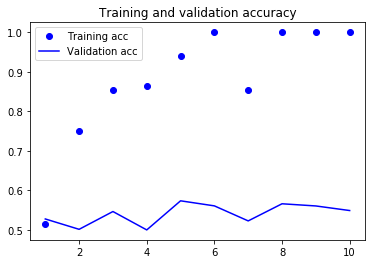

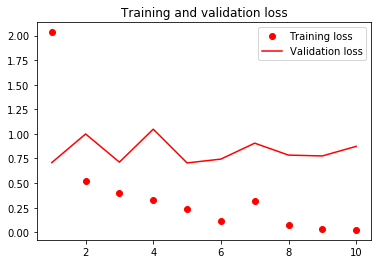

In [20]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s. This is pretty low, but with such a small training set it is not unexpected.

Before moving forward, let's take quick inventory of what we can do:
   * Turn raw text into something that a neural net can process
   * Use the `Embedding` layer to learn task-specific token embeddings
   * Leverage pre-trained word embeddings to get an extra boost on NLP problems with limited data

## Recurrent Neural Nets

A major characteristic of most neural networks, such as densely-connected networks and convnets, is that they have no memory. Each input to them gets processed independently, with no state kept in-between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entrie sequence to the network at once; i.e. turn it into a single datapoint. Such networks are called "feedforward networks". 

Recurrent Neural Networks (RNNs) process sequences by iterating through the sequence and maintaining a "state" containing information relative to what they have seen so far; i.e. these networks maintain some of the context of a sequence. In effect, RNNs are a type of neural network that has an internal loop. The state of the RNN is reset in-between processing two different, independent sequences, so we still consider one sequence as a single datapoint, a single input into the network -- what changes is that this datapoint is no longer processed in a single step, rather, the network internally loops over sequence elements.

In general, this is too much of an oversimplification to have any real use. In state-of-the-art RNN models, one would typically use a `LSTM` (Long-Short Term Memory) or `GRU` (Gated Recurrent Units) layers. These variants help to solve the vanishing gradient problem and hence have longer memories than a simple RNN. We will not get into the details of how these two layers work but to say that they offer a way of saving information for later use. The GRU layer runs on the same principle but is somewhat streamlined and is thus cheaper to run, although it might not have quite as much representational power as the LSTM.

In [21]:
# Reload the dataset
maxlen = 500
max_features = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test  = preprocessing.sequence.pad_sequences(X_test,  maxlen=maxlen)

In [60]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 168s - loss: 0.4954 - acc: 0.7645 - val_loss: 0.3179 - val_acc: 0.8742
Epoch 2/10
20000/20000 [==============================] - 167s - loss: 0.2856 - acc: 0.8903 - val_loss: 0.3267 - val_acc: 0.8608
Epoch 3/10
20000/20000 [==============================] - 161s - loss: 0.2300 - acc: 0.9130 - val_loss: 0.3469 - val_acc: 0.8836
Epoch 4/10
20000/20000 [==============================] - 165s - loss: 0.2072 - acc: 0.9244 - val_loss: 0.3338 - val_acc: 0.8710
Epoch 5/10
20000/20000 [==============================] - 164s - loss: 0.1722 - acc: 0.9389 - val_loss: 0.3420 - val_acc: 0.8836
Epoch 6/10
20000/20000 [==============================] - 161s - loss: 0.1554 - acc: 0.9435 - val_loss: 0.5392 - val_acc: 0.8402
Epoch 7/10
20000/20000 [==============================] - 160s - loss: 0.1456 - acc: 0.9496 - val_loss: 0.3400 - val_acc: 0.8786
Epoch 8/10
20000/20000 [========================

In [61]:
def plot_history(history):
    acc      = history.history['acc']
    val_acc  = history.history['val_acc']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

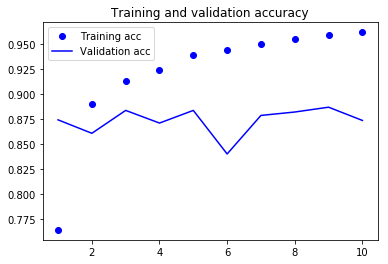

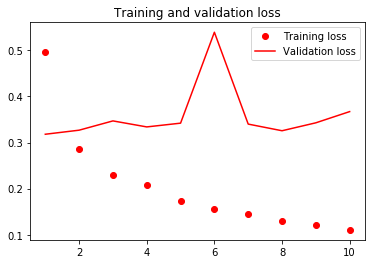

In [62]:
plot_history(history)

So we achieve a validation accuracy of ~87%; not bad considering we are truncating the full sequences. On the other hand, it is also not groundbreaking. One might do better by optimizing the hyperparmeters of the model, such as the dimensionality of the embeddings or LSTM. We might also benefit by some regularization. But honestly, the reason is mostly that analyzing the global, long-term structure of reviews (what LSTM is really good at) isn't very helpful for a sentiment analysis problem. Such a basic problem is very well solved by simply looking at what words occur in each review and at what frequency. But there are far more difficult NLP problems out there, where the strength of LSTM will become apparent: in particular, question answering and machine translation. 

### Recurrent Dropout

Dropout is used frequently to fight over-fitting in typical feedforward neural nets, consisting of randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. However, to corretly apply dropout in recurrent networks is not trivial. Instead of applying a random dropout mask for each timestep, you must instead apply the same dropout mask for each timestep of a series. What's more: in order to regularize the repressentations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead disrupt this error signal and be harmful to the learning process. 

Let's add dropout to our LSTM layer and see how it impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many epochs. 

In [ ]:
from keras.optimizers import RMSprop
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 182s - loss: 0.5645 - acc: 0.7315 - val_loss: 0.4212 - val_acc: 0.8168
Epoch 2/20
18048/20000 [==========================>...] - ETA: 16s - loss: 0.3780 - acc: 0.8452

In [ ]:
plot_history(history)